In [46]:
  from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [47]:
import os

In [48]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/chest-xray-pneumonia')

In [49]:
os.getcwd()

'/content/gdrive/MyDrive/Colab Notebooks/chest-xray-pneumonia'

In [50]:
!ls

 cat.json
'Copy of Image_Classification_with_Pneumonia (1).ipynb'
'Copy of Image_Classification_with_Pneumonia.ipynb'
 dataset
 Final_Image_Classification_with_Pneumonia.ipynb
 Final_Model.json
 Image_Classification_with_Pneumonia.ipynb
 Mobinenetv2
 output
 sampleTest_Pictures


In [51]:
import matplotlib
matplotlib.use("Agg")
%matplotlib inline

In [52]:
# Importing the libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import seaborn as sns
import cv2

In [53]:
TRAIN_PATH = './dataset/fid/training'
TEST_PATH = './dataset/fid/testing'
VAL_PATH = './dataset/fid/validation'

In [54]:
# Defining a function for plotting the count of data against each class in each directory
def plotData(dirPath):
    # Get the path to the normal and pneumonia sub-directories
    normal_cases_dir = dirPath+ '/0/'
    pneumonia_cases_dir = dirPath + '/1/'

    # Get the list of all the images
    normal_cases = glob.glob(normal_cases_dir + '*.jpeg')
    pneumonia_cases = glob.glob(pneumonia_cases_dir + '*.jpeg')

    # An empty list. We will insert the data into this list in (img_path, label) format
    data1 = []

    # Go through all the normal cases. The label for these cases will be 0
    for img in normal_cases:
        data1.append((img,0))

    # Go through all the pneumonia cases. The label for these cases will be 1
    for img in pneumonia_cases:
        data1.append((img, 1))

    # Get a pandas dataframe from the data we have in our list 
    data1 = pd.DataFrame(data1, columns=['image', 'label'],index=None)
    #print(data1)

    # Shuffle the data 
    data1 = data1.sample(frac=1.).reset_index(drop=True)
    #print(data1)    
    
    # Get the counts for each class
    cases_count = data1['label'].value_counts()
    print(cases_count)

    # Plot the results 
    plt.figure(figsize=(10,8))
    sns.barplot(x=cases_count.index, y= cases_count.values)
    plt.title('Number of cases', fontsize=14)
    plt.xlabel('Case type', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
    plt.show()

1    3077
0    1139
Name: label, dtype: int64


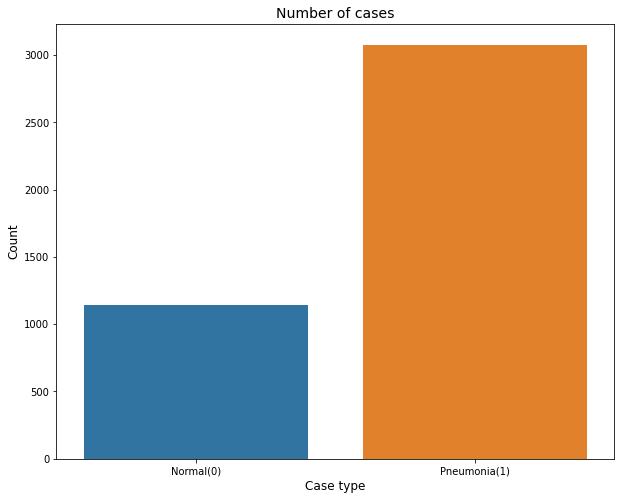

In [55]:
plotData(TRAIN_PATH)

1    855
0    317
Name: label, dtype: int64


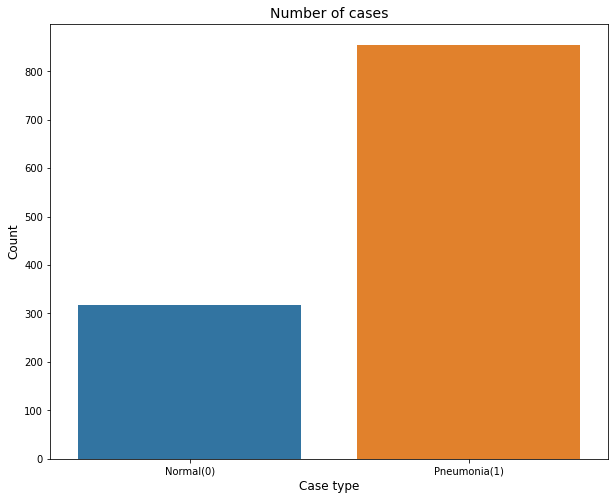

In [56]:
plotData(TEST_PATH)

1    341
0    127
Name: label, dtype: int64


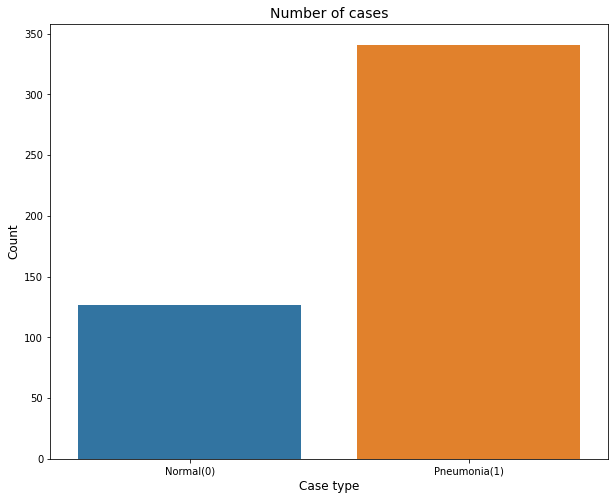

In [57]:
plotData(VAL_PATH)

In [58]:
# Defining a method to get the number of files given a path
def retrieveNumberOfFiles(path):
    list1 = []
    for file_name in glob.iglob(path+'/**/*.jpeg', recursive=True):
        list1.append(file_name)
    return len(list1)

In [59]:
# Checking for the total number of image paths in training, validation and testing directories
totalTrain = retrieveNumberOfFiles(TRAIN_PATH)
totalVal = retrieveNumberOfFiles(VAL_PATH)
totalTest = retrieveNumberOfFiles(TEST_PATH)

print("Train:", totalTrain)
print("Test:", totalTest)
print("Validatation:", totalVal)

Train: 4216
Test: 1172
Validatation: 468


In [60]:
# Defining a method to get the number of files given a path
def getAllFiles(path):
    list1 = []
    for file_name in glob.iglob(path+'/**/*.jpeg', recursive=True):
        list1.append(file_name)
    return list1

In [61]:
# Retrieving all file paths from train directory
allTrainFiles = getAllFiles(TRAIN_PATH)
allTrainFiles[:2]

['./dataset/fid/training/1/person549_bacteria_2306.jpeg',
 './dataset/fid/training/1/person331_bacteria_1528.jpeg']

In [62]:
### Calculating the total number of training images against each class and then store the class weights in a dictionary
## To Retrive Train file path of particular folder.
trainLabels = [int(p.split(os.path.sep)[-2]) for p in allTrainFiles]
#print(trainLabels)

## To convert into categorical.
trainLabels1 = to_categorical(trainLabels)
#print(trainLabels1)

## To Count Total value trainLabels.
classTotals = trainLabels1.sum(axis=0)
#print("Class Total Values",classTotals)

classWeight = dict()
## Looping over all classes and calculate the class weights
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]
    #print(classWeight[i], classTotals[i], classTotals.max())

# OR

#print(classTotals.max() / classTotals[0])
#print(classTotals.max() / classTotals[1])

###We are going to pass this late while fitting the model, which will help out in
#Training the model.

In [63]:
# Initialize the training data augmentation object
trainAug = ImageDataGenerator(
	preprocessing_function=preprocess_input,
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2, 
	shear_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")

In [64]:
# Initialize the validation data augmentation object
valAug = ImageDataGenerator(preprocessing_function=preprocess_input)

In [65]:
BATCH_SIZE = 16
INIT_LR = 1e-4
EPOCHS = 20
CLASSES = ["normal","pneumonia"]

In [66]:
# Initialize the training generator
trainGen = trainAug.flow_from_directory(
	TRAIN_PATH,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE)

Found 4216 images belonging to 2 classes.


In [67]:
# Initialize the validation generator
valGen = valAug.flow_from_directory(
	VAL_PATH,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=BATCH_SIZE)

Found 468 images belonging to 2 classes.


In [68]:
# Initialize the testing generator
testGen = valAug.flow_from_directory(
	TEST_PATH,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=BATCH_SIZE)

Found 1172 images belonging to 2 classes.


In [69]:
# Loading the MobileNetV2, ensuring the head Full Connected layers are left off / removed
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [70]:
# Construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
## Average pooling computes the average of the elements present in the region of feature map covered by the filter.
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
## We flatten the output of the convolutional layers to create a single long feature vector. 
headModel = Flatten(name="flatten")(headModel) 
## The main advantage of using the ReLU function over other activation functions is that it does not activate all the neurons at the same time.
headModel = Dense(128, activation="relu")(headModel)
## Dropout is a technique where randomly selected neurons are ignored during training.
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation="softmax")(headModel)

In [71]:
# Placing the head model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)                                                    

In [72]:
# Loop over all the layers of the base model and freeze them so that they are 
# not updated during the training process
for layer in baseModel.layers:
    layer.trainable = False

    

In [73]:
# Compiling the model
## Decay updates the learning rate by a decreasing factor in each epoch
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [74]:
outputPath = '/content/gdrive/MyDrive/Colab Notebooks/chest-xray-pneumonia/output'

In [30]:
# Using ModelCheckpoint to store the best performing model based on val_loss
MCName = os.path.sep.join([outputPath, "weights-{epoch:03d}-{val_loss:.4f}.hdf5"])
checkpoint = ModelCheckpoint(MCName, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
callbacks = [checkpoint]

In [31]:
# Fitting the model on training data
print("Model Fitting")
model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=valGen,
    validation_steps=totalVal // BATCH_SIZE,
    class_weight=classWeight,
    callbacks=callbacks,
    epochs=EPOCHS)

Model Fitting
Epoch 1/20
263/263 [==============================] - ETA: 0s - loss: 0.6792 - accuracy: 0.7888
Epoch 1: val_loss improved from inf to 0.36008, saving model to /content/gdrive/MyDrive/Colab Notebooks/chest-xray-pneumonia/output/weights-001-0.3601.hdf5
263/263 [==============================] - 780s 3s/step - loss: 0.6792 - accuracy: 0.7888 - val_loss: 0.3601 - val_accuracy: 0.8534
Epoch 2/20
263/263 [==============================] - ETA: 0s - loss: 0.4371 - accuracy: 0.8802
Epoch 2: val_loss improved from 0.36008 to 0.33246, saving model to /content/gdrive/MyDrive/Colab Notebooks/chest-xray-pneumonia/output/weights-002-0.3325.hdf5
263/263 [==============================] - 246s 934ms/step - loss: 0.4371 - accuracy: 0.8802 - val_loss: 0.3325 - val_accuracy: 0.8491
Epoch 3/20
263/263 [==============================] - ETA: 0s - loss: 0.3783 - accuracy: 0.8960
Epoch 3: val_loss did not improve from 0.33246
263/263 [==============================] - 253s 962ms/step - loss: 0

In [32]:
json_string = model.to_json()

In [33]:
with open("Mobinenetv2", "w") as f:
  f.write(json_string)

In [76]:
import keras

In [77]:
with open("Mobinenetv2", "r") as f:
  loaded_json_string = f.read()

model = keras.models.model_from_json(loaded_json_string)

In [34]:
outputPath

'/content/gdrive/MyDrive/Colab Notebooks/chest-xray-pneumonia/output'

In [35]:
# Loading the best performing model
# Please specify the model name from the output folder which has the lowest val_loss
path1 = outputPath + '/weights-011-0.2421.hdf5'
fModel = load_model(path1)

In [36]:
# Predicting on the test data
# The numpy.argmax() function returns indices of the max element of the array in a particular axis.
print("Predicting on the test data")
predTest = fModel.predict(x=testGen, steps=(totalTest // BATCH_SIZE) + 1)
predTest = np.argmax(predTest, axis=1)

Predicting on the test data
74/74 [==============================] - 295s 4s/step


In [37]:
# Printing the Classification Report
print(classification_report(testGen.classes, predTest, target_names=testGen.class_indices.keys()))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87       317
           1       0.99      0.90      0.94       855

    accuracy                           0.92      1172
   macro avg       0.89      0.94      0.91      1172
weighted avg       0.94      0.92      0.92      1172



In [38]:
# Computing the confusion matrix and and using the same to derive the 
# accuracy, sensitivity, and specificity
# Accuracy = TP + TN / TP + TN + FP + FN
# Sensitivity = TP / TP + FN
# Specificity = TN / FP + TN
cm = confusion_matrix(testGen.classes, predTest)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# Printing the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[309   8]
 [ 83 772]]
acc: 0.9224
sensitivity: 0.9748
specificity: 0.9029


In [39]:
# Defining a method to plot training and validation accuracy and loss
def training_plot(H, N, plotPath):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [41]:
# Setting the path to save the serialized model after training
MODEL_PATH = os.path.sep.join([outputPath, "PneumoniaPrediction.model"])

# Setting the path for the output training history plots
PLOT_PATH = os.path.sep.join([outputPath, "TrainingHistoryPlot.png"])

In [43]:
# Plotting the graph
training_plot(MF, EPOCHS, PLOT_PATH)

In [44]:
# Serialize/Writing the model to disk
print("Serializing network...")
fModel.save(MODEL_PATH, save_format="h5")

Serializing network...
